In [71]:
%matplotlib inline
import glob

import uproot
import numpy as np
import uproot_methods
import matplotlib.pyplot as plt
import concurrent.futures
import functools
import pandas as pd

# local
import utils
import manager

In [72]:
m = manager.Manager("redis://:mypass@uaf-10.t2.ucsd.edu:50010")

In [110]:
df = m.get_worker_info()
print("We have {} workers".format(df.shape[0]))
df.tail()

We have 74 workers


,addr,name,age,id,idle
72,169.228.132.135:39990,namin__sdsc-36.t2.ucsd.edu__mytask1__10183532.7,6438,215,74
73,169.228.132.167:47268,namin__sdsc-68.t2.ucsd.edu__mytask1__10183531.29,6462,198,72
74,169.228.132.167:47230,namin__sdsc-68.t2.ucsd.edu__mytask1__10183531.28,6467,195,72
75,169.228.130.145:47654,namin__cabinet-11-11-8.t2.ucsd.edu__mytask1__1...,6682,166,72
76,169.228.132.172:46004,namin__sdsc-73.t2.ucsd.edu__mytask1__10183530.34,6728,155,73


In [74]:
%%time
def f(x):
    return x**2
m.local_map(f,range(10),progress_bar=False)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 116 µs


[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

In [75]:
%%time
m.remote_map(f,range(10),return_metadata=False)

CPU times: user 47 ms, sys: 2 ms, total: 49 ms
Wall time: 43.3 ms


[0, 25, 36, 4, 1, 81, 49, 9, 64, 16]

In [76]:
fnames = glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run201*-Nano1June2019*/*.root")
def f(fname):
    return uproot.open(fname)["Events"].array("MET_pt").mean()
results = m.remote_map(f,fnames[:30])

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa5681ac2e8>)

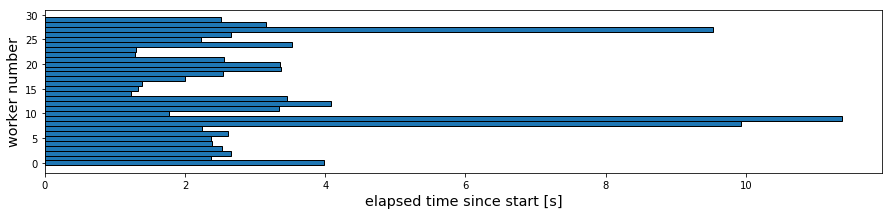

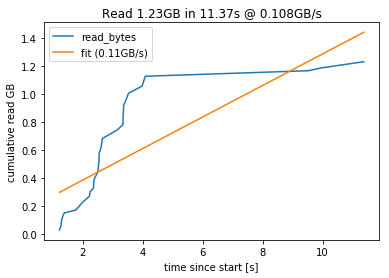

In [77]:
utils.plot_timeflow(results)
utils.plot_cumulative_read(results)

In [111]:
@functools.lru_cache(maxsize=128)
def get_chunking(filelist, chunksize, treename="Events", workers=12):
    """
    Return 2-tuple of
    - chunks: triplets of (filename,entrystart,entrystop) calculated with input `chunksize` and `filelist`
    - total_nevents: total event count over `filelist`
    """
    print("Recomputing")
    chunks = []
    executor = None if len(filelist) < 5 else concurrent.futures.ThreadPoolExecutor(workers)
    nevents = 0
    for fn, nentries in uproot.numentries(filelist, treename, total=False, executor=executor,).items():
        nevents += nentries
        for index in range(nentries // chunksize + 1):
            chunks.append((fn, chunksize*index, chunksize*(index+1)))
    return chunks,nevents

In [112]:
%%time
fnames = sorted(glob.glob("/hadoop/cms/store/user/namin/nanoaod/DoubleMuon__Run*/*.root"))

# For testing, just 60 files (doublemu has ~130 total)
# fnames = fnames[:60]

chunks, total_nevents = get_chunking(tuple(fnames),int(0.5e6))
print("{} chunks of {} files, with a total of {:.5g} events".format(len(chunks),len(fnames),total_nevents))

Recomputing
448 chunks of 133 files, with a total of 1.922e+08 events
CPU times: user 18.9 s, sys: 408 ms, total: 19.3 s
Wall time: 3.9 s


In [113]:
def get_mll_hist(args,bins=np.linspace(0,500,1000)):
    fname,entrystart,entrystop = args
    """
    return 
    - event count considered
    - array of histogram bin counts for m(mumu) for nmu==2 events
    """
    f = uproot.open(fname)
    t = f["Events"]
    p4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(
        *t.arrays(
            ["Muon_pt","Muon_eta","Muon_phi","Muon_mass"],
            outputtype=tuple,
            namedecode="ascii",
            entrystart=entrystart,
            entrystop=entrystop,
        ),
    )
    nevents = len(p4)
    pairs = p4[p4.counts==2]
    mll = (pairs[:,0]+pairs[:,1]).mass
    counts,_ = np.histogram(np.clip(mll,bins[0],bins[-1]),bins=bins)
    return (nevents,counts)

In [114]:
%%time
bins = np.logspace(np.log10(0.5),np.log10(1000),num=300)
# override the binning via currying
f = functools.partial(get_mll_hist,bins=bins)
# run a "pilot" locally first, so if it crashes, we won't submit them remotely
f(chunks[0]);
results = m.remote_map(f,chunks);

CPU times: user 2.87 s, sys: 150 ms, total: 3.02 s
Wall time: 35.5 s


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa560f6c1d0>)

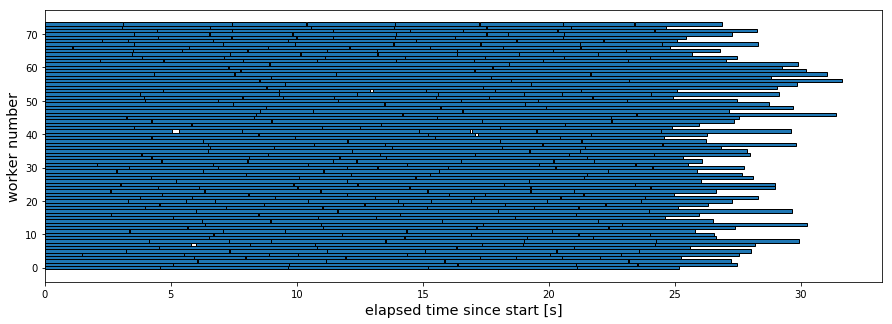

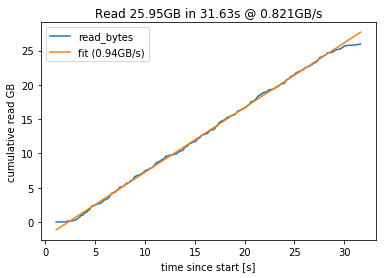

In [115]:
utils.plot_timeflow(results)
utils.plot_cumulative_read(results)

9.9701e+07 total muons


Text(0, 0.5, 'Entries')

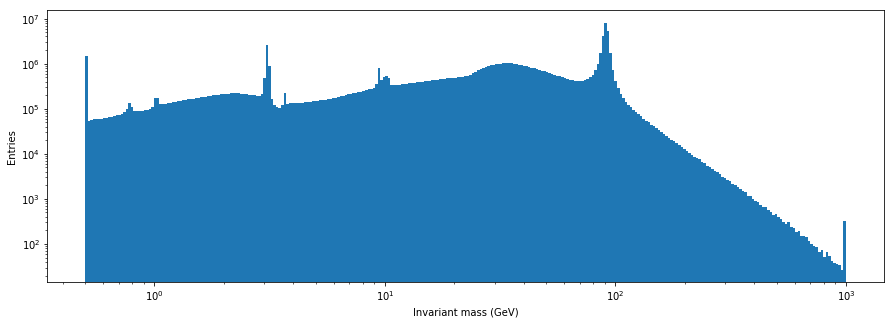

In [89]:
counts = sum(r[0][1] for r in results)
print("{:.5g} total muons".format(counts.sum()))
# log spaced bin centers (matching the inputs)
centers = np.power(10.,0.5*(np.log10(bins[:-1])+np.log10(bins[1:])))
fig,ax = plt.subplots(figsize=(15,5))
ax.hist(centers,weights=counts,bins=bins);
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Invariant mass (GeV)")
ax.set_ylabel("Entries")

In [107]:
m.r.info()

{'active_defrag_hits': 0,
 'active_defrag_key_hits': 0,
 'active_defrag_key_misses': 0,
 'active_defrag_misses': 0,
 'active_defrag_running': 0,
 'allocator_active': 3145728,
 'allocator_allocated': 2377648,
 'allocator_frag_bytes': 768080,
 'allocator_frag_ratio': 1.32,
 'allocator_resident': 11264000,
 'allocator_rss_bytes': 8118272,
 'allocator_rss_ratio': 3.58,
 'aof_current_rewrite_time_sec': -1,
 'aof_enabled': 0,
 'aof_last_bgrewrite_status': 'ok',
 'aof_last_cow_size': 0,
 'aof_last_rewrite_time_sec': -1,
 'aof_last_write_status': 'ok',
 'aof_rewrite_in_progress': 0,
 'aof_rewrite_scheduled': 0,
 'arch_bits': 64,
 'atomicvar_api': 'sync-builtin',
 'blocked_clients': 74,
 'client_recent_max_input_buffer': 2,
 'client_recent_max_output_buffer': 0,
 'cluster_enabled': 0,
 'config_file': '/home/users/namin/sandbox/htmap/redis/redis-5.0.5/myconf.conf',
 'configured_hz': 10,
 'connected_clients': 77,
 'connected_slaves': 0,
 'evicted_keys': 0,
 'executable': '/home/users/namin/sandbo